<a href="https://colab.research.google.com/github/pravvvv/Amazon_fine_food_reviews/blob/main/Amazon_Fine_Food_Applying_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# Reading Data

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn import datasets, neighbors
from sklearn.metrics import roc_auc_score
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import os

C:\Users\pmallya1\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\pmallya1\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  Preprocessing

## Preprocessing Text

1. Remove html tags
2. Remove punctuations, special characters
3. Check for alpha numeric (avoid in most cases)
4. Words have to be >2 length
5. Convert to lowercase
6. Remove stopwords
7. Snowball Stemming 

The data here has already been preprocessed

# Applying Logistic Regression

##Function definitions

In [ ]:
#normalize
def c_vs_AUC_CV_Train(c_set,mean_auc_train,mean_auc_cv):
        plt.plot(c_set[:],mean_auc_train[0:],color='b', label='Train')
        plt.plot(c_set[:],mean_auc_cv[0:],color='r', label='CV')
        plt.title("Log c vs AUC" )
        plt.xlabel("Log c")
        plt.ylabel("AUC")
        plt.legend()
        plt.ylim(0, 1)
        plt.show()
def LogReg_apply(test_c_set,X_tr,X_cv,y_tr,y_cv,pen):
    cv_scores = []
    mean_auc_train = []
    mean_auc_cv = []
    n = 10
    for c in tqdm(test_c_set):
        # for each iteration, randomly hold out 20% of the data as CV set
        clf = LogisticRegression(penalty=pen, C=c)
        clf.fit(X_tr, y_tr)
        pred_train = clf.predict_proba(X_tr)
        pred_cv = clf.predict_proba(X_cv)
        mean_auc_cv.append(roc_auc_score(y_cv, pred_cv[:,1]))
        mean_auc_train.append(roc_auc_score(y_tr, pred_train[:,1]))

    df = pd.DataFrame({
        'c' : test_c_set,
        'c Log' : np.log(test_c_set),
        'AUC_CV' : mean_auc_cv,
        'AUC_train' : mean_auc_train
    })
    return df

In [ ]:
def test_results(best_c,X_train_ncv, X_cv, X_test,y_train_ncv, y_cv,y_test,pen):
    clf = LogisticRegression(penalty=pen, C=best_c)
    clf.fit(X_train_ncv, y_train_ncv)
    pred_train = clf.predict_proba(X_train_ncv)
    pred_cv = clf.predict_proba(X_cv)
    pred_test = clf.predict_proba(X_test)
    fpr1, tpr1, thresholds = roc_curve(y_train_ncv, pred_train[:,1])
    fpr2, tpr2, thresholds = roc_curve(y_cv, pred_cv[:,1])
    fpr3, tpr3, thresholds = roc_curve(y_test, pred_test[:,1])
    print("The AUC score for train data is : ",roc_auc_score(y_train_ncv, pred_train[:,1]))
    print("The AUC score for CV data is : ",roc_auc_score(y_cv, pred_cv[:,1]))
    print("The AUC score for test data is : ",roc_auc_score(y_test, pred_test[:,1]))
    plt.plot(fpr1,tpr1,'r',label = 'Train data')
    plt.plot(fpr2,tpr2,'b',label = 'CV data')
    plt.plot(fpr3,tpr3,'g',label = 'Test data')
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    plt.show()
    import seaborn as sn
    #https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities
    import matplotlib.pyplot as plt1
    y_pred = np.argmax(pred_test, axis=1)
    conf_mat = confusion_matrix(y_test, y_pred )
    conf_mat_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
    sn.heatmap(conf_mat , annot=True ,fmt='.1f' )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(classification_report(y_test, y_pred))

In [ ]:
test_c_set = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

In [ ]:
X_cv_bow.shape

(14000, 9667)

## Logistic Regression on BOW

### Applying Logistic Regression with L1 regularization on BOW 

In [ ]:
X_tr = X_tr_bow
X_te = X_te_bow
X_cv = X_cv_bow


In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l1')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [37:16<00:00, 149.12s/it]


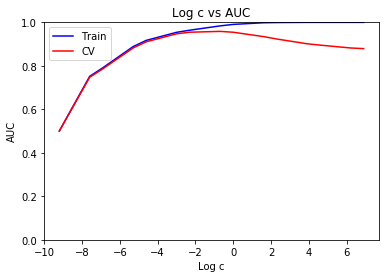

0.5 is the optimal c 


In [ ]:

c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = (best_c_row.iloc[0]['c'])
print(str(best_c) + " is the optimal c ")



The AUC score for train data is :  0.9837836859508264
The AUC score for CV data is :  0.9585395460914349
The AUC score for test data is :  0.9592145364687734


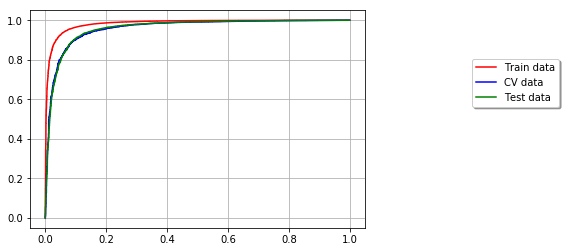

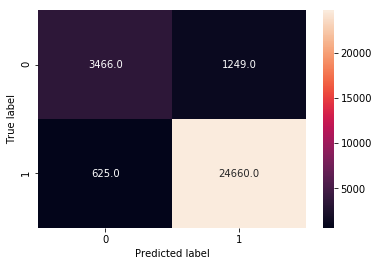

             precision    recall  f1-score   support

          0       0.85      0.74      0.79      4715
          1       0.95      0.98      0.96     25285

avg / total       0.94      0.94      0.94     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l1')

#### Calculating sparsity on weight vector obtained using L1 regularization on BOW

In [ ]:
best_c = 0.5
#best model and results
best_c_model = LogisticRegression(penalty='l1', C=best_c)
best_c_model.fit(X_tr, y_train_ncv)
pred = best_c_model.predict(X_te)
#https://stackoverflow.com/questions/38708621/how-to-calculate-percentage-of-sparsity-for-a-numpy-array-matrix
non_zero = np.count_nonzero(best_c_model.coef_)
total_val = np.product(best_c_model.coef_.shape)
sparsity = (total_val - non_zero) / total_val
density = non_zero / total_val

print("Sparsity of the weight vector : ",sparsity)

Sparsity of the weight vector :  0.7269059687596979


### Applying Logistic Regression with L2 regularization on BOW

In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l2')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [01:23<00:00,  5.54s/it]


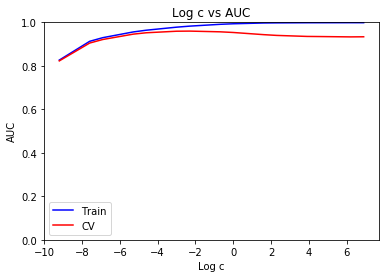

0.1 is the optimal c 


In [ ]:

c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = best_c_row.iloc[0]['c']
print(str(best_c) + " is the optimal c ")



The AUC score for train data is :  0.9826639291966167
The AUC score for CV data is :  0.959782650874475
The AUC score for test data is :  0.9611287483871562


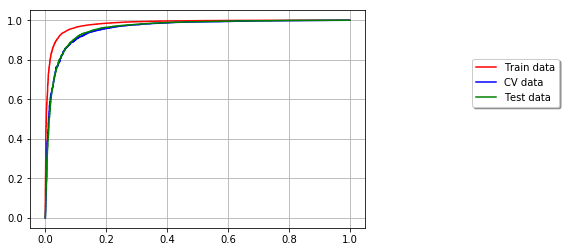

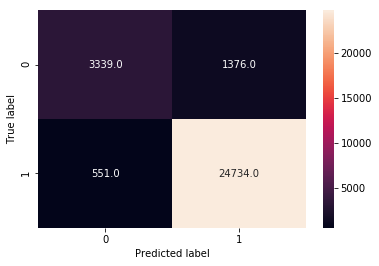

             precision    recall  f1-score   support

          0       0.86      0.71      0.78      4715
          1       0.95      0.98      0.96     25285

avg / total       0.93      0.94      0.93     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l2')

####  Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation

#calculate the weights before adding noise

# Please write all the code with proper documentation
best_c = 0.1


#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#Get the weights W after fit your model with the data X.

best_c_model = LogisticRegression(penalty='l2', C=best_c)
best_c_model.fit(X_tr, y_train_ncv)
weight1 = best_c_model.coef_
#Add a noise to the X (X' = X + e)
n_tr = X_tr.astype(float)

n_tr += np.random.uniform(-0.001,0.001,1)


In [ ]:
#We fit the model again on data X' and get the weights W'
n_c_model = LogisticRegression(penalty='l2', C=best_c )
n_c_model.fit(n_tr, y_train_ncv  )
weight2 = n_c_model.coef_


In [ ]:
#Add the small eps value(to eliminate the divisible by zero error) to W and W’ 
# i.e W=W+10^-6 and W’ = W’+10^-6
weight1 += 10**-6
weight2 += 10**-6

#find the % change between W and W', percentage_change_vector = 
# (| (W-W') / (W) |)*100)

pc_chg = abs((weight1-weight2) / (weight1))*100

In [ ]:
pc_chg.T.shape

(9667, 1)

In [ ]:
#calculate the 0th, 10th, 20th, 30th, ...100th percentiles

percentiles = range(0,101,10)
perc_change = []
for i in percentiles:
    perc_change.append(np.percentile(pc_chg,i))
import pandas as pd 


In [ ]:
df = pd.DataFrame({
    'Percentile ' : percentiles,
    '% change' : perc_change ,
})

print(df)

    Percentile      % change
0             0     0.000081
1            10     0.055654
2            20     0.128844
3            30     0.220669
4            40     0.332366
5            50     0.475676
6            60     0.679043
7            70     0.981100
8            80     1.526920
9            90     3.095638
10          100  1954.946677


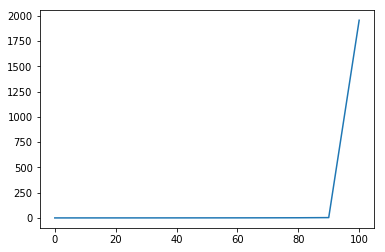

In [ ]:
import matplotlib.pyplot as plt
plt.plot(percentiles,perc_change)

Since there is a clear spike in the values from 90 to 100 we are going to plot another chart between them

In [ ]:
percentiles = range(90,101,1)
perc_change = []
for i in percentiles:
    perc_change.append(np.percentile(pc_chg,i))
import pandas as pd 

In [ ]:
df = pd.DataFrame({
    'Percentile ' : percentiles,
    '% change' : perc_change ,
})
print(df)

    Percentile      % change
0            90     3.095638
1            91     3.423817
2            92     3.855933
3            93     4.341580
4            94     5.021285
5            95     5.954488
6            96     7.568854
7            97    10.434285
8            98    15.637425
9            99    30.029665
10          100  1954.946677


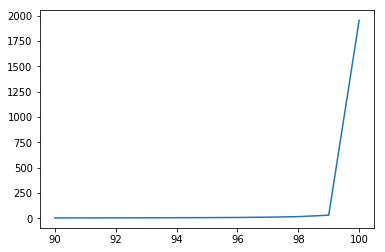

In [ ]:
import matplotlib.pyplot as plt
plt.plot(percentiles,perc_change)

Taking another look at the changes from 99 to 100

    Percentile   % change
0          98.0     15.64
1          98.1     16.46
2          98.2     17.02
3          98.3     18.73
4          98.4     19.67
5          98.5     20.94
6          98.6     22.14
7          98.7     23.14
8          98.8     25.50
9          98.9     27.75
10         99.0     30.03
11         99.1     32.83
12         99.2     35.21
13         99.3     38.15
14         99.4     46.33
15         99.5     51.23
16         99.6     65.57
17         99.7     76.51
18         99.8    144.90
19         99.9    262.79


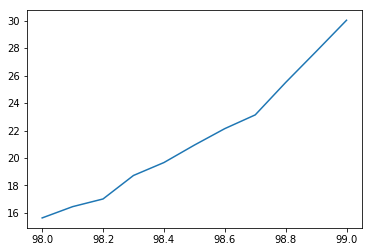

In [ ]:
percentiles = np.arange(98,100,0.1)
perc_change = []
for i in percentiles:
    perc_change.append(np.percentile(pc_chg,i))
import pandas as pd 
pc_float = []
for i in perc_change:
    pc_float.append(round(float(i),2))
df = pd.DataFrame({
    'Percentile ' : percentiles,
    '% change' : pc_float ,
})
print(df)

#zooming values less than 30

ind = 0
for i in pc_float:
    if i>30:
        mi = ind 
        break
    ind += 1


import matplotlib.pyplot as plt
plt.plot(percentiles[:mi+1],pc_float[:mi+1])

In [ ]:
print(len(feat))

9667


In [ ]:
print(len(list((pc_chg.T))))

9667


In [ ]:
#considering 30% as threshold

count_vect = CountVectorizer(min_df=10)  #in scikit-learn
X_tr_bow = count_vect.fit_transform(X_train_ncv)
X_te_bow = count_vect.transform(X_test)

#considering 30% as threshold

#considering 30% as threshold

feat = count_vect.get_feature_names()
len(feat)
df = pd.DataFrame({
    'Feature names' : feat,
    'pc change' : (list((pc_chg.T)))
})

df = df[df['pc change']>30]

feat_greater_30 = df.sort_values('pc change', axis=0, ascending=False, 
                                 kind='quicksort')
pc_feat_30 = pc_chg[np.where(pc_chg>30)].size
print("% of features that did not change more than 30% : " ,((weight1.size - 
      pc_feat_30)/(weight1.size)*100))
print("The features which get changed more than 30% are : ",
      np.array(feat_greater_30['Feature names']))

% of features that did not change more than 30% :  98.98624185372918
The features which get changed more than 30% are :  ['leaning' 'sufficiently' 'melamine' 'listmania' 'swanson' 'disclose'
 'mcdonald' 'creativity' 'activity' 'kindle' 'recipies' 'suds' 'islands'
 'lactic' 'stone' 'containers' 'browns' 'isolated' 'bha' 'problematic'
 'dubble' 'garlicky' 'kuerig' 'hormel' 'deserved' 'rolls' 'grab'
 'successfully' 'glance' 'concentration' 'ulcers' 'measurements'
 'uploaded' 'hamburger' 'beggin' 'bladder' 'jif' 'jacobs' 'bridge'
 'sinuses' 'kindly' 'manna' 'brussels' 'spring' 'deep' 'gourd' 'organics'
 'kicked' 'gulped' 'grand' 'petite' 'pantothenate' 'ferment' 'stench'
 'intoxicating' 'soccer' 'blank' 'options' 'begun' 'celebrate' 'density'
 'reportedly' 'briefly' 'morsels' 'dab' 'prominently' 'roasts'
 'inconvenience' 'frise' 'prep' 'standpoint' 'sacrificing' 'reflects'
 'wegmans' 'unfamiliar' 'booster' 'pleasurable' 'ship' 'genuine' 'prairie'
 'saffron' 'allergens' 'tolerated' 'redbull

As 98.98% did not change more than 30% we could conclude there was no multicollinearity

#### Feature Importance on BOW

##### Top 10 important features of positive class 

In [ ]:
# Please write all the code with proper documentation
best_c = 0.1
#find_pos_feat(X_train_rev_sum, X_test_rev_sum,best_c,'l2','BoW')

#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#best model and results
count_vect = CountVectorizer(min_df=10)  #in scikit-learn
X_tr_bow = count_vect.fit_transform(X_train_ncv)
X_te_bow = count_vect.transform(X_test)
feat = count_vect.get_feature_names()
best_c_model = LogisticRegression(penalty='l2', C=best_c)
best_c_model.fit(X_tr_bow, y_train_ncv)
pred = best_c_model.predict(X_te_bow)
feature_coef_ = best_c_model.coef_[0]

df = pd.DataFrame({'coef' : feature_coef_, 
                   'Feature names ' : feat })
#Top 10 +ve features 
#print(feature_coef_.shape)

sorted_coef = df.sort_values('coef',ascending = False)
print("Top 10 positive features : ")
print(sorted_coef[0:10])



Top 10 positive features : 
          coef Feature names 
2955  1.618506      excellent
2249  1.529473      delicious
6148  1.317665        perfect
513   1.308141        awesome
4979  1.273949          loves
3749  1.222569          great
9632  1.185331            yum
9642  1.175937          yummy
253   1.157224        amazing
9525  1.114127      wonderful


##### Top 10 important features of negative class 

In [ ]:
print("Top 10 negative features : ")
print(sorted_coef.tail(10))

Top 10 negative features : 
          coef  Feature names 
7173 -1.160058             rip
786  -1.162003           bland
2435 -1.337576  disappointment
2433 -1.354738    disappointed
4082 -1.358771        horrible
9629 -1.423757            yuck
8639 -1.446898        terrible
515  -1.461610           awful
9563 -1.692824           worst
2434 -1.921643   disappointing


## Logistic Regression on TFIDF

### Applying Logistic Regression with L1 regularization on TFIDF

In [ ]:
X_tr = X_tr_tfidf 
X_te = X_te_tdidf
X_cv = X_cv_tdidf 


In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l1')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [00:46<00:00,  3.09s/it]


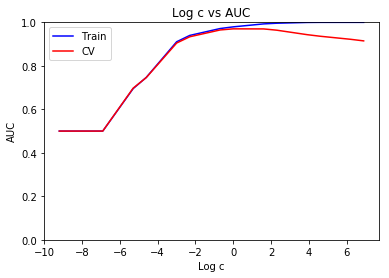

1.0 is the optimal c 


In [ ]:

c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = (best_c_row.iloc[0]['c'])
print(str(best_c) + " is the optimal c ")



The AUC score for train data is :  0.9793098131543849
The AUC score for CV data is :  0.9701649184419356
The AUC score for test data is :  0.97190649711004


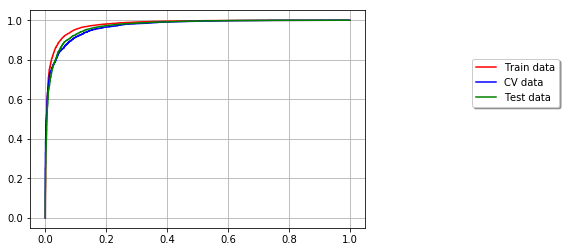

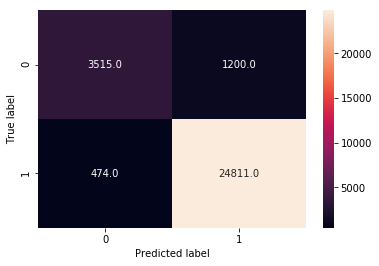

             precision    recall  f1-score   support

          0       0.88      0.75      0.81      4715
          1       0.95      0.98      0.97     25285

avg / total       0.94      0.94      0.94     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l1')

### Applying Logistic Regression with L2 regularization on TFIDF

In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l2')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [00:16<00:00,  1.09s/it]


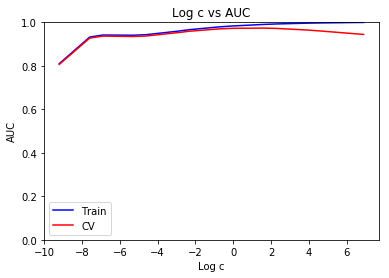

5.0 is the optimal c 


In [ ]:

c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = (best_c_row.iloc[0]['c'])
print(str(best_c) + " is the optimal c ")



The AUC score for train data is :  0.990480724454438
The AUC score for CV data is :  0.9736001950578763
The AUC score for test data is :  0.9746897416115876


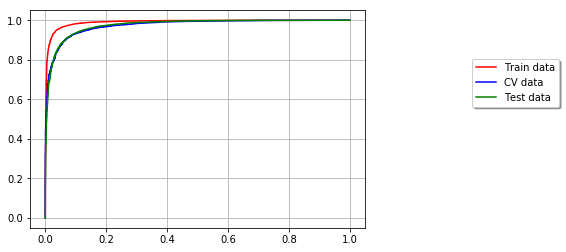

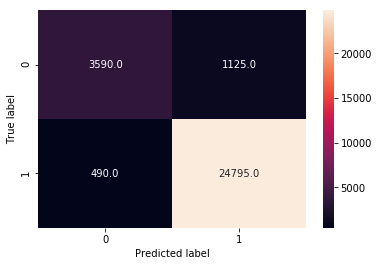

             precision    recall  f1-score   support

          0       0.88      0.76      0.82      4715
          1       0.96      0.98      0.97     25285

avg / total       0.94      0.95      0.94     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l2')

### Feature importance on TFIDF

#### Top 10 important features of positive class

In [ ]:
best_c = 5.0
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 50 )
X_tr_tfidf = tf_idf_vect.fit_transform(X_train_ncv)
X_te_tdidf = tf_idf_vect.transform(X_test)

feat = tf_idf_vect.get_feature_names()
best_c_model = LogisticRegression(penalty='l2', C=best_c)
best_c_model.fit(X_tr_tfidf, y_train_ncv)
pred = best_c_model.predict(X_te_tdidf)
feature_coef_ = best_c_model.coef_[0]

df = pd.DataFrame({'coef' : feature_coef_, 
                   'Feature names ' : feat })
#Top 10 +ve features 
#print(feature_coef_.shape)

sorted_coef = df.sort_values('coef',ascending = False)
print("Top 10 positive features : ")
print(sorted_coef[0:10])

Top 10 positive features : 
           coef    Feature names 
2503  15.697466             great
1375  13.195372         delicious
2385  11.814463              good
434   11.503813              best
1797  11.458475         excellent
4323   9.934389           perfect
3362   9.115798             loves
5830   8.815639             tasty
322    8.716624           awesome
3860   8.683415  not disappointed


#### Top 10 important features of negative class

In [ ]:
print("Top 10 negative features : ")
print(sorted_coef.tail(10))

Top 10 negative features : 
           coef Feature names 
2785  -8.109674       horrible
6193  -8.131049      two stars
5896  -9.062026       terrible
3827  -9.126667            not
324   -9.244480          awful
4010  -9.254203      not worth
6559 -10.482978          worst
1488 -10.679879   disappointed
1491 -10.718940  disappointing
3895 -11.092797       not good


## Logistic Regression on AVG W2V

### Applying Logistic Regression with L1 regularization on AVG W2V

In [ ]:
X_tr = X_tr_avgw2v 
X_te = X_te_avgw2v
X_cv = X_cv_avgw2v

In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l1')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [00:55<00:00,  3.73s/it]


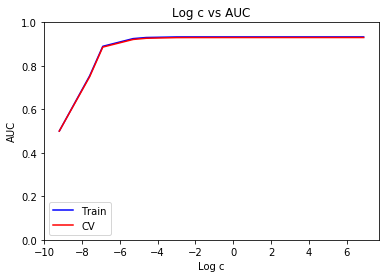

1000.0 is the optimal c 


In [ ]:
c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = (best_c_row.iloc[0]['c'])
print(str(best_c) + " is the optimal c ")

The AUC score for train data is :  0.9330513970030286
The AUC score for CV data is :  0.9302256242738085
The AUC score for test data is :  0.9340499430563685


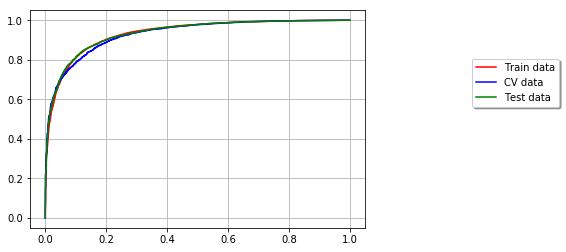

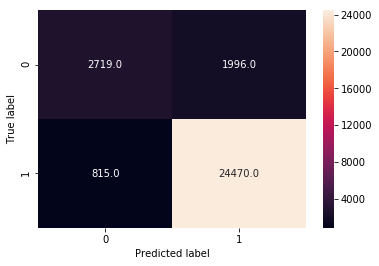

             precision    recall  f1-score   support

          0       0.77      0.58      0.66      4715
          1       0.92      0.97      0.95     25285

avg / total       0.90      0.91      0.90     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l1')

### Applying Logistic Regression with L2 regularization on AVG W2V

In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l2')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [00:13<00:00,  1.10it/s]


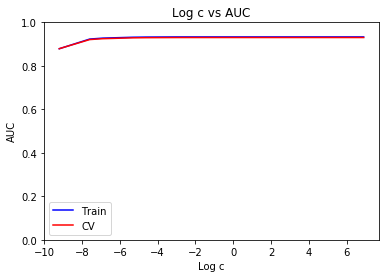

10.0 is the optimal c 


In [ ]:
c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = (best_c_row.iloc[0]['c'])
print(str(best_c) + " is the optimal c ")

The AUC score for train data is :  0.9330507420468458
The AUC score for CV data is :  0.9302356371238849
The AUC score for test data is :  0.93405625078768


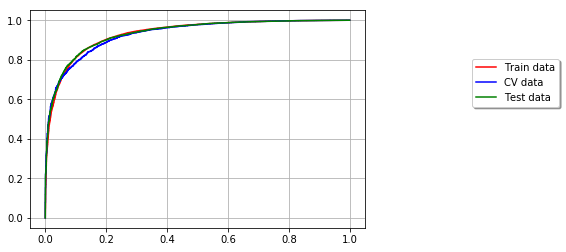

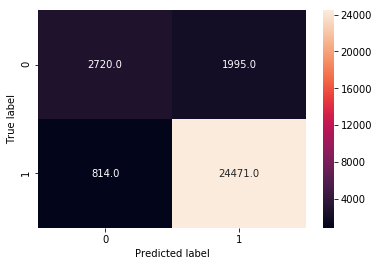

             precision    recall  f1-score   support

          0       0.77      0.58      0.66      4715
          1       0.92      0.97      0.95     25285

avg / total       0.90      0.91      0.90     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l2')

## Logistic Regression on TFIDF W2V

### Applying Logistic Regression with L1 regularization on TFIDF W2V

In [ ]:
X_tr = X_tr_tfidfw2v
X_te = X_test_tfidfw2v
X_cv = X_cv_tfidfw2v

In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l1')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [00:43<00:00,  2.88s/it]


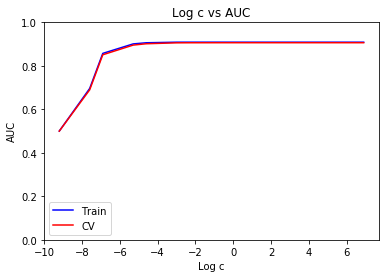

100.0 is the optimal c 


In [ ]:
c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = (best_c_row.iloc[0]['c'])
print(str(best_c) + " is the optimal c ")

The AUC score for train data is :  0.9087249147866411
The AUC score for CV data is :  0.9064046005305451
The AUC score for test data is :  0.9079403307071391


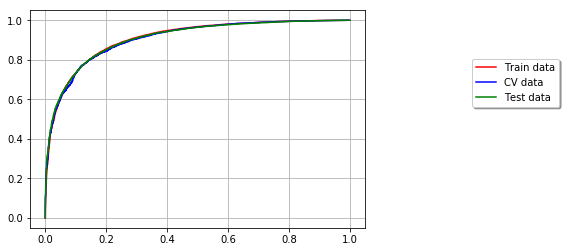

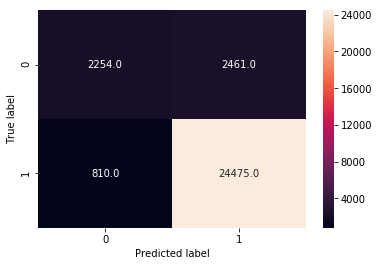

             precision    recall  f1-score   support

          0       0.74      0.48      0.58      4715
          1       0.91      0.97      0.94     25285

avg / total       0.88      0.89      0.88     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l1')

### Applying Logistic Regression with L2 regularization on TFIDF W2V

In [ ]:
LR_df = LogReg_apply(test_c_set,X_tr,X_cv,y_train_ncv,y_cv,'l2')

100%|¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦| 15/15 [00:14<00:00,  1.01it/s]


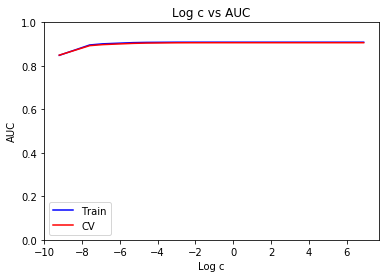

100.0 is the optimal c 


In [ ]:
c_vs_AUC_CV_Train(LR_df['c Log'],LR_df['AUC_train'],LR_df['AUC_CV'])
best_c_row = LR_df.loc[LR_df['AUC_CV'] == max(LR_df['AUC_CV'] )]
best_c = (best_c_row.iloc[0]['c'])
print(str(best_c) + " is the optimal c ")

The AUC score for train data is :  0.9087148863633463
The AUC score for CV data is :  0.906411741770788
The AUC score for test data is :  0.9079356082965959


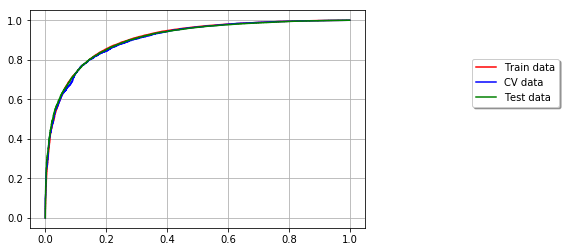

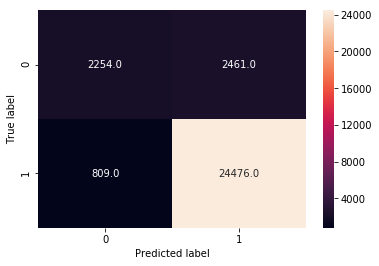

             precision    recall  f1-score   support

          0       0.74      0.48      0.58      4715
          1       0.91      0.97      0.94     25285

avg / total       0.88      0.89      0.88     30000



In [ ]:
test_results(best_c,X_tr,X_cv, X_te,y_train_ncv, y_cv,y_test,'l2')

# Summary

In [ ]:
# Please compare all your models using Prettytable library

bow_l1 = ['BoW - L1',0.98,0.96,0.96]
bow_l2 = ['BoW - L2',0.98,0.96,0.96]
tfidf_l1 = ['TFIDF - L1',0.98,0.97,0.97]
tfidf_l2 = ['TFIDF - L2',0.99,0.97,0.97]
avgw2v_l1 = ['AVG W2V - L1',0.93,0.93,0.93]
avgw2v_l2 = ['AVG W2V - L2',0.93,0.93,0.93]
tfidfw2v_l1 = ['TFIDF W2V - L1',0.91,0.91,0.91]
tfidfw2v_l2 = ['TFIDF W2V - L2',0.91,0.91,0.91]

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorization","AUC Train " , "AUC CV ", 
                 "AUC Test "]

x.add_row(bow_l1)
x.add_row(bow_l2)
x.add_row(tfidf_l1)
x.add_row(tfidf_l2)
x.add_row(avgw2v_l1)
x.add_row(avgw2v_l2)
x.add_row(tfidfw2v_l1)
x.add_row(tfidfw2v_l2)

print(x)

+----------------+------------+---------+-----------+
| Vectorization  | AUC Train  | AUC CV  | AUC Test  |
+----------------+------------+---------+-----------+
|    BoW - L1    |    0.98    |   0.96  |    0.96   |
|    BoW - L2    |    0.98    |   0.96  |    0.96   |
|   TFIDF - L1   |    0.98    |   0.97  |    0.97   |
|   TFIDF - L2   |    0.99    |   0.97  |    0.97   |
|  AVG W2V - L1  |    0.93    |   0.93  |    0.93   |
|  AVG W2V - L2  |    0.93    |   0.93  |    0.93   |
| TFIDF W2V - L1 |    0.91    |   0.91  |    0.91   |
| TFIDF W2V - L2 |    0.91    |   0.91  |    0.91   |
+----------------+------------+---------+-----------+


# Observation

    1.Since the data was imbalanced AUC values were used 
    2.BoW and TFIDF are giving excellent predictions 
    3.Even though there is a drop in AUC values for TFIDF and AVG W2V overall the model is much more faster and reliable than KNN despite having considered 100k datapoints
    4.Review text and summary text were considered during the training of the model 